
Node Classification with DGL and Pytorch
============================


# Initializing workspace


In [ ]:
#Install dgl on gg collab
import os 
os.system("pip install dgl -f https://data.dgl.ai/wheels/repo.html >> out.txt")

0

In [ ]:
# Import

import random
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import networkx as nx
import dgl
import dgl.function as fn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda

import sklearn.utils as sk

! pip3 install pickle5
import pickle5 as pickle

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
     |████████████████████████████████| 256 kB 9.3 MB/s 


In [ ]:
#Initialize workspace with github and gg drive

from google.colab import drive
drive.mount('/content/drive')
! ls
%cd drive/MyDrive/ProjetLong
! git clone https://github.com/Viperine2022/projet_long_GCN_internet

KeyboardInterrupt: ignored

In [ ]:
#Connect to gg drive gg drive

from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/ProjetLong/projet_long_GCN_internet


Mounted at /content/drive
/content/drive/MyDrive/ProjetLong/projet_long_GCN_internet


In [ ]:
# Pull
! git pull

remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 15 (delta 8), reused 15 (delta 8), pack-reused 0
Unpacking objects: 100% (15/15), done.
From https://github.com/Viperine2022/projet_long_GCN_internet
   fbc2041..1e7df6a  main       -> origin/main
Updating fbc2041..1e7df6a
Fast-forward
 .../data_visualization-checkpoint.ipynb            |   475 +-
 .../CAIDA/data/CAIDA_AS_CLASSIFICATION/toto.txt    |     5 -
 .../CAIDA/data/LIST_AS_CLASSIFICATION_20210301.txt | 71434 ------------------
 .../CAIDA/data/LIST_AS_CLASSIFICATION_20210401.txt | 71665 ------------------
 .../CAIDA/data/LIST_AS_RELATIONSHIP_20210301.txt   | 71434 ------------------
 .../CAIDA/data/LIST_AS_RELATIONSHIP_20210401.txt   | 71669 -------------------
 IMPLANTATION/CAIDA/data/tata.txt                   |     4 -
 IMPLANTATION/CAIDA/data/titi.txt                   |     1 -
 IMPLANTATION/CAIDA/data/toto.txt                   

# Loading PeeringDB Dataset
--------------------

In [ ]:
# Lecture des datasets PeeringDB au format csv

#AS features
dataset_path = 'IMPLANTATION/PeeringDB/data_GCN/dataset_AS_pDB_.csv'
dataset_AS = pd.read_csv(dataset_path)

# IXP features
dataset_path = 'IMPLANTATION/PeeringDB/data_GCN/dataset_IXP_pDB_.csv'
dataset_IXP = pd.read_csv(dataset_path)



In [ ]:
# Train mask, Val mask, Test mask génération

nb_nodes = len(dataset_AS.index)
print(nb_nodes)

# train : 80% ; val : 10% ; test 10% 
perm = np.random.permutation(nb_nodes)
A_train = perm[:int(0.8*nb_nodes)]
A_val = perm[int(0.8*nb_nodes): int(0.9*nb_nodes)]
A_test = perm[int(0.9*nb_nodes):]


train_mask_int=np.zeros((nb_nodes))
val_mask_int=np.zeros((nb_nodes))
test_mask_int=np.zeros((nb_nodes))

train_mask_int[A_train] = 1
val_mask_int[A_val] = 1
test_mask_int[A_test] = 1


train_mask = train_mask_int > 0.5 
val_mask = val_mask_int > 0.5 
test_mask = test_mask_int > 0.5 

#dictionnaire de mask à ajouter en features au graphe au format networkX

dict_train_mask = dict(zip(np.arange(nb_nodes), train_mask))
isinstance(dict_train_mask, dict)

dict_val_mask = dict(zip(np.arange(nb_nodes), val_mask))
isinstance(dict_val_mask, dict)

dict_test_mask = dict(zip(np.arange(nb_nodes), test_mask))
isinstance(dict_test_mask, dict)


11407


True

In [ ]:
#Pour PeeringDB

AS_feat = dataset_AS.iloc[:,range(0,6)]
AS_lab = dataset_AS.iloc[:,range(6,7)]

IXP_feat = dataset_IXP.iloc[:,range(0,1)]


AS_features = AS_feat.to_numpy().astype(float)
IXP_features = IXP_feat.to_numpy().astype(float)
AS_labels = AS_lab.to_numpy().astype(float)



In [ ]:
# Loading Graph with pickle5
path_to_protocol5 = 'IMPLANTATION/PeeringDB/data_GCN/graph_pDB_.pickle'
with open(path_to_protocol5, "rb") as fh:
  G_dBP = pickle.load(fh)


# Conversion of the graph to dgl format
G_dgl_dBP = dgl.bipartite_from_networkx(G_dBP, utype='bipartite=0',etype = 'edges', vtype='bipartite=1')


# Adding features and labels to dgl graph
G_dgl_dBP.nodes['bipartite=0'].data["feat"] = torch.tensor(AS_features)
G_dgl_dBP.nodes['bipartite=0'].data["label"] = torch.tensor(AS_labels)
G_dgl_dBP.nodes['bipartite=1'].data["feat2"] = torch.tensor(IXP_features)

# Adding masks on graph 
G_dgl_dBP.nodes['bipartite=0'].data["train_mask"] = torch.tensor(train_mask)
G_dgl_dBP.nodes['bipartite=0'].data["test_mask"] = torch.tensor(test_mask)
G_dgl_dBP.nodes['bipartite=0'].data["val_mask"] = torch.tensor(val_mask)



In [ ]:
g = G_dgl_dBP

In [ ]:
block = dgl.to_block(g)


# Undersampling of train set

Random Undersampling

# Defining GCN

In [ ]:
# Does not work

class SAGEConv(nn.Module):


    def __init__(self, in_feat, out_feat):
        

    def forward(self, g, h):
        
        

class Model(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(Model, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats)
        self.conv2 = SAGEConv(h_feats, num_classes)

    def forward(self, mfgs, x):
        
        return h


In [ ]:
#Training torch GCN
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']


    for e in range(300):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)


        
        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
    return pred, labels



# Test GCN


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns


model2 = GCN(g.ndata['feat'].shape[1], 16, 3)
pred2, labels2 = train(g, model2.double())





/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 0, loss: 2.141, val acc: 0.326 (best 0.326), test acc: 0.653 (best 0.653)


KeyboardInterrupt: ignored

Accuracy sur base de test : 0.3166293393057111
              precision    recall  f1-score   support

           0       0.09      0.07      0.08       331
           1       0.89      0.17      0.29      5400
           2       0.22      0.92      0.36      1413

    accuracy                           0.32      7144
   macro avg       0.40      0.39      0.24      7144
weighted avg       0.72      0.32      0.29      7144



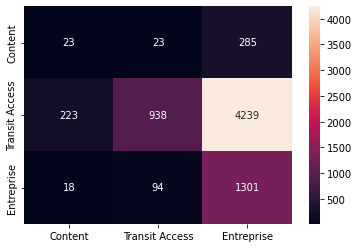

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

classe = ["Content","Transit Access","Entreprise"]
N_CLASSES = 3

conf2=confusion_matrix(labels2[test_mask],pred2[test_mask])

sns.heatmap(data=conf2,fmt='.0f',xticklabels=classe,yticklabels=classe,annot=True)

print(classification_report(labels2[test_mask],pred2[test_mask]))


0.5881676227577471


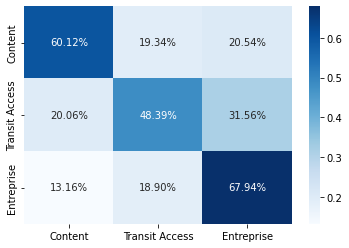

In [ ]:
sns.heatmap(np.transpose(np.transpose(conf2)/np.sum(conf2,axis=1)), annot=True, 
            fmt='.2%', cmap='Blues',xticklabels=classe,yticklabels=classe)